# MLiM 25440 Homework 5
### Brendan Sanderson

##### Imports and set up

In [0]:
from fastai import *
from fastai.vision import *

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Data Setup

In [0]:
path = Path('/content/drive/My Drive/HW5/data/IDC_regular_ps50_idx5/')
fnames=get_files(path, recurse=True)
pattern= r'([^/_]+).png$'
print('Number of images:', len(fnames))

Number of images: 24257


In [0]:
import zipfile
#zip_path = '/content/drive/My Drive/HW5/data/balanced_IDC.zip'
#zip_path = '/content/drive/My Drive/HW5/data/balanced_IDC_30k.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('.')

#### a. **[Augmentation]** Implement data augmentation by defining a transform with `fastai`. Apply your transform to a batch of images from the dataset and include the result.

I chose to make my tranformations slightly more extreme than the normal `get_transforms` transformations

In [0]:
tfms = get_transforms(max_rotate=30,max_zoom=1.2,flip_vert=True)

In [0]:
class MemoryImageList(ImageDataBunch):
    _map = {}
    def open(self, i):
        item = self._map.get(str(i))
        if isinstance(item, Image):
            return item
        item = super().open(i)
        self._map[str(i)] = item
        return item

In [0]:
data = MemoryImageList.from_name_re(path, fnames, pattern, ds_tfms=tfms, size=50, bs=64,num_workers=2).normalize()

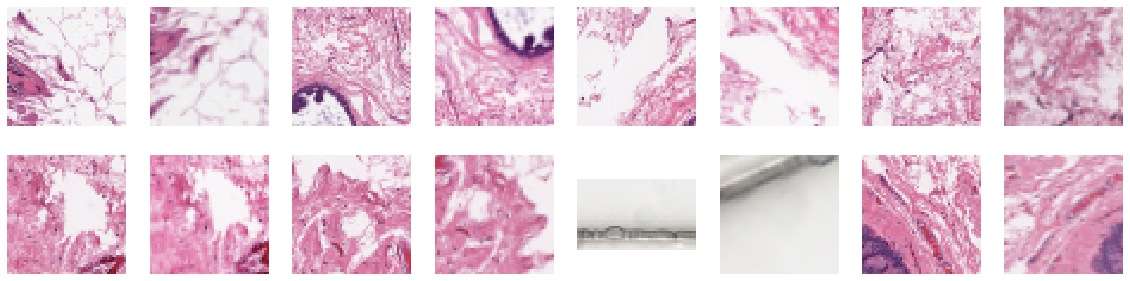

In [0]:
def plots_f(rows, cols, width, height, **kwargs):
    for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten()):
      if i % 2 == 0:
        img = open_image(fnames[int(i/2)])
        img.show(ax=ax)
      else:
        img = open_image(fnames[int(i/2)])
        img.apply_tfms(tfms[0], **kwargs).show(ax=ax)

plots_f(2, 8, 20, 5, size=50)

Above are some transformed images next to their untransformed version.


1. How can data augmentation improve the performance of machine learning models?

  Data augmentation improves the performance of machine learning models by allowing the model to classify a more general and natural set of images. It is rarely the case that all images that you may be looking at are taken from the same angle and same distance away. Thus, it is extremely useful to randomly transform your dataset through data augmentation, so that it can learn to classify a more diverse set of data such as those that may be naturally taken and in turn avoid overfitting to specifically the dataset that you are given. Overall, data augmentation creates a more diverse set of data that models the model to learn the features for a more natural set of data.

2. Is augmentation only useful for training the model?

  No, it is useful also for testing and validation as using data augmentation for testing and validation helps to understand the prediction power of a model on a more general set of data. Again, as actual images are taken from different angles and depths, it we want to know the true predictive power of the model, we have to use data augmentation on the testing and validation in addition to the training. This is also a method to determine whether or not a model was overfitted as if it was, then it would perform worse until a test set that underwent data augmentation.

#### b. **[Learning Rate]** Choose a model from the documentation above and use cnn_learner to load this model and pass the data function defined in the previous step. Do not pretrain the model. Use fastai to find the optimal learning rate to train the model and include the loss plot.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


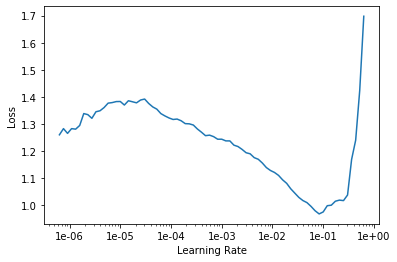

In [0]:
learner = cnn_learner(data, models.resnet18, model_dir ="/content/drive/My Drive/HW5/models", metrics=[accuracy], pretrained = False)
learner.lr_find()
learner.recorder.plot()

1. How does the learning rate affect model training?

  When looking at extremely small learning rates, increasing the learning rate slightly increases the loss. However, the loss soon reaches a local maximum between 1e-05 and 1e-04. After this point, the loss slowly declines as the learning rate increases until it reaches a global minimum around 1e-01 and then the dramatically shoots upwards. 
  
  Learning rate seems to have 2 main tradeoffs: convergence precision and time to converge. A lower learning rate will allow the model to converge to a more precise value, but will take an immense amount of time to get to that point. A higher learning rate will converge quickly, but not converge to a very precise value. Using a learning rate graph truly helps to determine the ideal learning rate that is an efficient trade off between the two.
  
  There is definitely an ideal best learning rate. We dont want the learning rate to be so high that the model does not converge, but we also dont want it to be so low that it would take forever to properly converge.

2. Why might we consider different rates if we are using a pretrained model?

  If we are using a pretrained model, than the weights are already trained. We may want to consider a lower learning rate as we are no longer training an entirely new model, but instead just tweaking the model to specialize to our dataset. Thus, the necessary changes in the weights are much smaller as the weights has already converged to a fairly strong value and thus likely only need to move very slightly to converge to a value specific to this particular data.

#### c. **[Training from Scratch]** Train the model for 1 epoch using the fit_one_cycle method and the optimal learning rate found in the previous step.


The greatest slope in the learning rate curve appears to be between 0.01 and 0.1. Thus, I will choise 0.05 as the optimal learning rate.

In [0]:
learner.fit_one_cycle(1,max_lr=slice(0.05))

epoch,train_loss,valid_loss,accuracy,time
0,0.346203,0.292847,0.880849,22:24


1. Report the loss and accuracy of the model.

  The losses are 0.346 for training and 0.293 for the validation. The accuracy is about 88.1%

2. How do they compare to the baseline accuracy i.e. random chance?

  In the dataset, there are 913 1's and 3,938 0's. This means that if we randomly guess no tumor, we would have an 81.2% accuracy and if we randomly guessed tumor, than there would be a 18.8% accuracy. Thus, the expected baseline accuracy at most 81.2% if we guess all 0's. The accuracy here is definitely greater than this baseline. This model's accuracy is greater by 7.9%. This may not seem like much, but given that the accuracy is 88.1% it is fairly significant as increases at higher accuracies are more significant. Thus, I would say that this model definitely performs better than the baseline, but it still definitely could improve given that it is only about 8% better than the baseline.

#### d. **[Pretraining and Fine-tuning]** Now redefine the `cnn_learner` so that it is pretrained. By default, only the last prediction layer will be unfrozen or trainable. Train the model for one epoch as before. Report the accuracy.

In [0]:
learner = cnn_learner(data, models.resnet18, model_dir ="/content/drive/My Drive/HW5/models", metrics=[accuracy], pretrained = True)
learner.fit_one_cycle(1,max_lr=slice(0.05))

epoch,train_loss,valid_loss,accuracy,time
0,0.312401,0.245766,0.903113,01:34


1. How does `fastai` pretrain models?

  `fastai` pretrains models by training a new model on a generic dataset and them saving the weights. These saved models are pretrained as anyone can use them as a starting off point for their own model. The starting weights and network architecture are already predetermined by the pretrained model. As the model already had been trained, the weights are not random, but instead already trained to look for specific features common across all images such as shapes. I chose to use `resnet18`, which comes from `torchvision`. `resnet18` is pretrained on more than 1 million images from `ImageNet`, which were classified into over 1000 objects.
    
2. Can a model trained on non-medical data be useful for medical images?

  Definitely, models recognize objects in images and all objects both non-medical and medical are defined by similar features. Whether it be distinct shape, contrast to the background, or having a defined texture, models just detect, seperate and classify different types of objects. If images are able to determine whether or not a tumor is cancerous, then a model trained on non-medical data will be able to help classify the tumors (assuming it was trained well enough) as it will be able to determine the differences in the cancerous and non-cancerous tumors just as it can tell the difference between animal species.

3. Why do we only train the prediction layer?

  We only train the prediction layer as a pretrained model was trained for a general set of objects. The model was pretrained to have well defined and valuable internal weights, but as the model was generically pretrained, the prediction layer does not have any sort of prediction power. Thus, we need to train the model to classify the classes within this specific dataset and by training the prediction layer we achieve this without disturbing the interal weight which already have great predictive power. As the internal weights are already trained to detect certain features in the images, it would be a waste of computational power to train all of the layers, so by training only the prediction layer, you are able to be efficient.

#### e. **[Unfreezing]** Using the pretrained model from the previous step, unfreeze all the layers, find the optimal learning rate, and train for at least one epoch.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


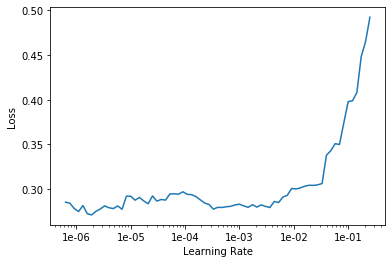

In [0]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(1,max_lr=slice(0.00025))

epoch,train_loss,valid_loss,accuracy,time
0,0.272588,0.228122,0.908885,01:36


1. Report the accuracy.

  The training loss is 0.273, the validation loss is 0.228, and the accuracy is 90.8%.

2. Why should we consider a different learning rate after unfreezing all the model layers?

  In a pretrained model, the weights have already been trained rigorously. Thus, we only want to slightly tweak the weights to specialize them to this set of data. Hence, we probably want to use a lower learning rate as we don't want to retrain all of weights from scratch and by using a lower learning rate it allows the weights to converge to a more precise value. From the graph, it appears that it does does not matter too much what we set our learning rate to as the loss is fairly constant until the learning rate gets large and it fails to converge.

#### f. **[Analysis]** Use fastai to plot the confusion matrix and use sklearn to plot the ROC curve and report the area under the curve (AUC).


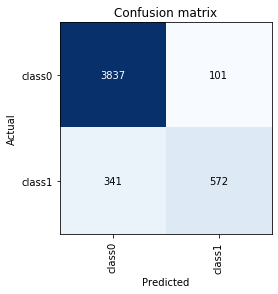

In [0]:
preds,y,losses = learner.get_preds(with_loss=True)
interpreter = ClassificationInterpretation(learner, preds, y, losses)
interpreter.plot_confusion_matrix()

The auc is 0.9405130564271956


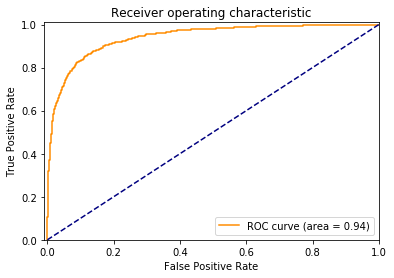

In [0]:
y_score = preds[:,1].numpy()
fpr, tpr, thresholds = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

print("The auc is", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

1. In your opinion, is the accuracy of the model acceptable for potential clinical application?

  The accuracy of the model is not acceptable for limited potential clinical application. An accuracy of about 91% still means 1 in 10 of patients will get falsely diagnosed. Thus, it certainly can not be used in place of a human's diagnosis as it would improperly diagnose 10% of the time. Even if humans had the same accuracy, society would be far more outraged if a machine made a false diagnosis then if a human did as they expect perfection out of machines. However, 91% is high and should not be discounted. If more work was put into this model, then it definitely could improve at least slightly. This would make it extremely useful as a secondary method of diagnosis in addition to human diagnosis. The conbination of the two would obviously produce better results than just a human and the human would be vary of the model's accuracy. Thus, I believe that the model is acceptable for potential clinical application as an addition method of diagnosis, but not as a method to replace human doctors' diagnososes.

2. Besides prediction accuracy, what else may a clinician consider when choosing a model?

  The number of false positives and false negatives is extremely important in addition to accuracy. A false negative is far more costly than a false positive as a false negative would lead to certain death. A false positive would just lead to unnecessary treatment and emotional harm, which is certianly bad, but far better than death. Also, a false positive will likely be fixed eventually as the doctor will likely run follow up a diagnosis. Thus, the number of false positives vs false negatives is extremely important, especially in the case of medicine. In this case, we have 341 false negatives compared to 101 false positives. Thus, this makes the model weaker due to the extreme amount false negatives and how costly a false negative is. 

  A similar comparison can be made from looking at the ROC graph and AUC value. Here, the AUC is is 0.94, which is a fairly good and means that their is a strong degree of class seperability. Also, the model is fairly good at predicting true positive values. However, it is important to note that 0.94 is very far from perfect and it is hard to justify a machine replacing a man until it is about perfect.

#### Write Up

It was really exciting to explore the potential power of pretrained models. Seeing how the accuracy improved when switching from a not pretrained model to a pretrained model and then also improved when switching to a pretrained with unfrozen weights was very educational. What I really found interesting is that unfreezing all of the layers only very slightly improved the accuracy (~0.6%). In addition, the pretrained model with frozen layers even outperformed the model that was trained on thie data without pretraining. This truly showed to me how powerful a pretrained model is as it was able to perform extremely well on the model even though the interal weights were not modified at all to fit this specific data set. It makes me beg the question of why we do not always try to use pretrained models. Also, given that the weights are  already trained, using pretrained models can also save a lot of computational power.

The greatest issue I had with this lab is that I found the `fastai` library far less intuitve than scikit learn and Keras. `fastai` uses a different vocabulary and uses a learner that takes data in as its constructor instead of a model that takes in data to its fit and predict functions, which seems extremely wierd as it is hard to really know what it is doing under the hood. However, I understand that there is likely some sort of computational benefit to this. It was definitely suprising how much `fastai` could do with a single method call, but I still feel like i prefer what we have used in the past given the intuitive nature. 

Overall, I really enjoyed this lab and enjoyed exploring a new library `fastai`, which I can hopefully find a time to use in the future. Also, pretrained networks were something I have not seen before or thought of. However, after this lab, it is evident to me that pretrained networks have an immense amount of benefits and I hope to apply them to my work outside of class.